In [312]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [313]:
from causacore import SyntheticData, Model
import numpy as np

np.random.seed(123) # Set seed for reproducibility

In [314]:
# Node specifications based on the final graph
node_specs = {
    "Input_A": {"mean": 100, "std": 20, "min": 0, "max": 200},
    "Input_B": {"mean": 120, "std": 30, "min": 0, "max": 240},
    "Input_C": {"mean": 80, "std": 15, "min": 0, "max": 160},
    "Config_A1": {"mean": 0.6, "std": 0.1, "min": 0, "max": 1, "r2": 0.3},
    "Config_A2": {"mean": 0.7, "std": 0.1, "min": 0, "max": 1, "r2": 0.3},
    "Config_A3": {"mean": 0.8, "std": 0.1, "min": 0, "max": 1, "r2": 0.3},
    "Config_B1": {"mean": 0.4, "std": 0.1, "min": 0, "max": 1, "r2": 0.3},
    "Config_B2": {"mean": 0.5, "std": 0.1, "min": 0, "max": 1, "r2": 0.3},
    "Config_B3": {"mean": 0.6, "std": 0.1, "min": 0, "max": 1, "r2": 0.5},
    "Config_C1": {"mean": 0.5, "std": 0.1, "min": 0, "max": 1, "r2": 0.3},
    "Config_C2": {"mean": 0.6, "std": 0.1, "min": 0, "max": 1, "r2": 0.3},
    "Yield_A1": {"mean": 0.6, "std": 0.1, "min": 0, "max": 1, "r2": 0.8},
    "Yield_A2": {"mean": 0.7, "std": 0.1, "min": 0, "max": 1, "r2": 0.85},
    "Yield_A3": {"mean": 0.8, "std": 0.1, "min": 0, "max": 1, "r2": 0.9},
    "Yield_B1": {"mean": 0.5, "std": 0.1, "min": 0, "max": 1, "r2": 0.8},
    "Yield_B2": {"mean": 0.6, "std": 0.1, "min": 0, "max": 1, "r2": 0.85},
    "Yield_B3": {"mean": 0.7, "std": 0.1, "min": 0, "max": 1, "r2": 0.9},
    "Yield_C1": {"mean": 0.4, "std": 0.1, "min": 0, "max": 1, "r2": 0.75},
    "Yield_C2": {"mean": 0.5, "std": 0.1, "min": 0, "max": 1, "r2": 0.8},
    "Output": {"mean": 0.9, "std": 0.05, "min": 0, "max": 1, "r2": 0.95}
}

# Edge specifications based on the final graph
edge_specs = [
    {"nodes": ("Input_A", "Yield_A1"), "effect": 1},
    {"nodes": ("Input_B", "Yield_B1"), "effect": 1},
    {"nodes": ("Input_C", "Yield_C1"), "effect": 1},
    {"nodes": ("Config_A1", "Yield_A1"), "effect": -1},
    {"nodes": ("Config_A1", "Config_A2"), "effect": 1},
    {"nodes": ("Config_A2", "Yield_A2"), "effect": 1},
    {"nodes": ("Config_A2", "Config_A3"), "effect": 1},
    {"nodes": ("Config_A3", "Yield_A3"), "effect": 1},
    {"nodes": ("Config_B1", "Yield_B1"), "effect": 1},
    {"nodes": ("Config_B2", "Yield_B2"), "effect": 1},
    {"nodes": ("Config_B2", "Config_B3"), "effect": 1},
    {"nodes": ("Config_B3", "Yield_B3"), "effect": 1},
    {"nodes": ("Config_C1", "Yield_C1"), "effect": 1},
    {"nodes": ("Config_C2", "Yield_C2"), "effect": 1},
    {"nodes": ("Yield_A1", "Yield_A2"), "effect": 1},
    {"nodes": ("Yield_A2", "Yield_A3"), "effect": 1},
    {"nodes": ("Yield_A3", "Output"), "effect": 1},
    {"nodes": ("Yield_B1", "Yield_B2"), "effect": 1},
    {"nodes": ("Yield_B1", "Yield_C1"), "effect": 1},
    {"nodes": ("Yield_B2", "Yield_B3"), "effect": 1},
    {"nodes": ("Yield_B3", "Output"), "effect": 1},
    {"nodes": ("Yield_C1", "Yield_C2"), "effect": 1},
    {"nodes": ("Yield_C2", "Output"), "effect": 1}
]

# Synthetic data generation
data_generator = SyntheticData(node_specs, edge_specs)
data = data_generator.generate_data(num_samples=365)

In [315]:
# Round data to 2dp and save to CSV
data.round(2).to_csv("production_data.csv", index=False)

In [316]:
nodes = list(node_specs.keys())
edges = [(edge["nodes"][0], edge["nodes"][1]) for edge in edge_specs]

# Save nodes and edges to JSON
import json
with open("nodes.json", "w") as f:
    json.dump(nodes, f)

with open("edges.json", "w") as f:
    json.dump(edges, f)

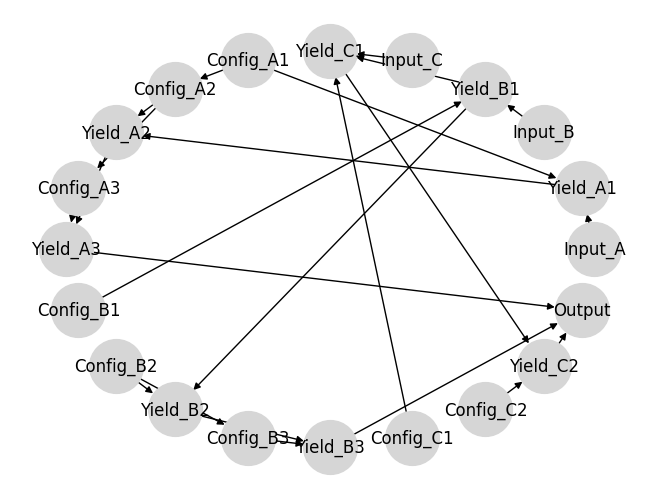

In [317]:

# Define and train the model
model = Model(nodes=nodes, edges=edges)
model.train(data)

# Plot diagnostics
model.diagnostics.plot()

In [318]:
optimal_config = model.query.find_best_actions(
    targets={"Output": "maximise"},
    actionable=["Config_A1", "Config_A2", "Config_A3", "Config_B1", "Config_B2", "Config_B3", "Config_C1", "Config_C2"],
)

optimal_config.round(2)

,Config_A1,Config_A2,Config_A3,Config_B1,Config_B2,Config_B3,Config_C1,Config_C2
0,0.62,0.88,0.95,0.48,0.5,0.55,0.56,0.59


In [319]:
action = optimal_config.to_dict(orient="list")
action = {k: v[0] for k, v in action.items()}
output_achieved_causal = data_generator.forward(action).mean().round(2)["Output"]

0.95

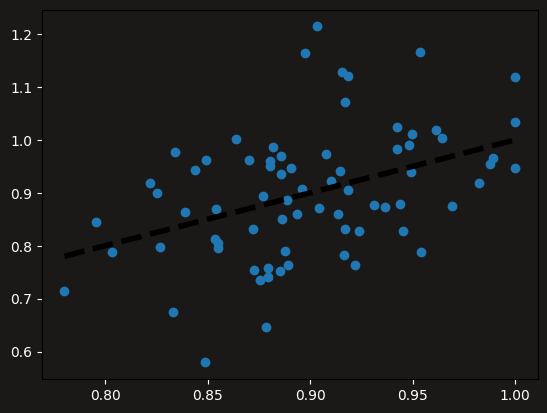

In [320]:
# Fit neural network
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = data.drop(columns=["Output"])
y = data["Output"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nn = MLPRegressor(hidden_layer_sizes=(256, 256, 256), max_iter=1000, random_state=42)
nn.fit(X_train, y_train)

y_pred = nn.predict(X_test)

mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

# Plot y_test vs y_pred
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)

In [321]:
output_original = data.head().mean().round(2)["Output"]

0.9

In [322]:
# Run optimisation routine using neural network to find optimal configuration
from scipy.optimize import minimize
import pandas as pd

actionable = ["Config_A1", "Config_A2", "Config_A3", "Config_B1", "Config_B2", "Config_B3", "Config_C1", "Config_C2"]

def objective_function(action: list):
    # Convert from (-inf, inf) to (0, 1)
    action = [1 / (1 + 2.718281828459045 ** -x) for x in action]
    new_values = {k: v for k, v in zip(actionable, action)}
    input_values = X.mean().to_dict()
    input_values.update(new_values)
    input_values = pd.DataFrame(input_values, index=[0])
    return -nn.predict(input_values)

initial_guess = [0] * len(actionable)
result = minimize(objective_function, initial_guess, method="BFGS")
result.x

action = {k: v for k, v in zip(actionable, result.x)}

# Convert from (-inf, inf) to (0, 1)
action = {k: 1 / (1 + 2.718281828459045 ** -v) for k, v in action.items()}

output_achieved_neuralnet = data_generator.forward(action).mean().round(2)["Output"]

0.72

In [ ]:
print(f"Original output: {output_original}")
print(f"Output achieved using causal model: {output_achieved_causal}")
print(f"Output achieved using neural network: {output_achieved_neuralnet}")